# Riddler Classic (2021-01-29)

This is my solution attempt to the [Riddler Classic for January 29, 2021](https://fivethirtyeight.com/features/can-you-guess-the-mystery-word/). The goal is to find four pre-chosen guesses that maximize the probability of winning the game of [Lingo](https://en.wikipedia.org/wiki/Lingo_(American_game_show)) on the fifth guess.

In [1]:
import urllib
import random
import string
import numpy as np
import re
import scipy.stats
import concurrent.futures
from collections import (Counter, defaultdict)
import matplotlib.pyplot as plt

plt.rc('font', family='monospace')
plt.rc('font', size=14)

First we extract the list of all five-letter words - the rest are irrelevant to the problem. There are 8636 five-letter words.

In [2]:
with urllib.request.urlopen("https://norvig.com/ngrams/enable1.txt") as f:
    FIVE = tuple(word.decode().strip().upper() for word in f if len(word.strip()) == 5)

NO_REPEATS = tuple(w for w in FIVE if len(set(w)) == 5)

FIVE_DICT = defaultdict(list)
for w in FIVE:
    FIVE_DICT[w[0]].append(w)

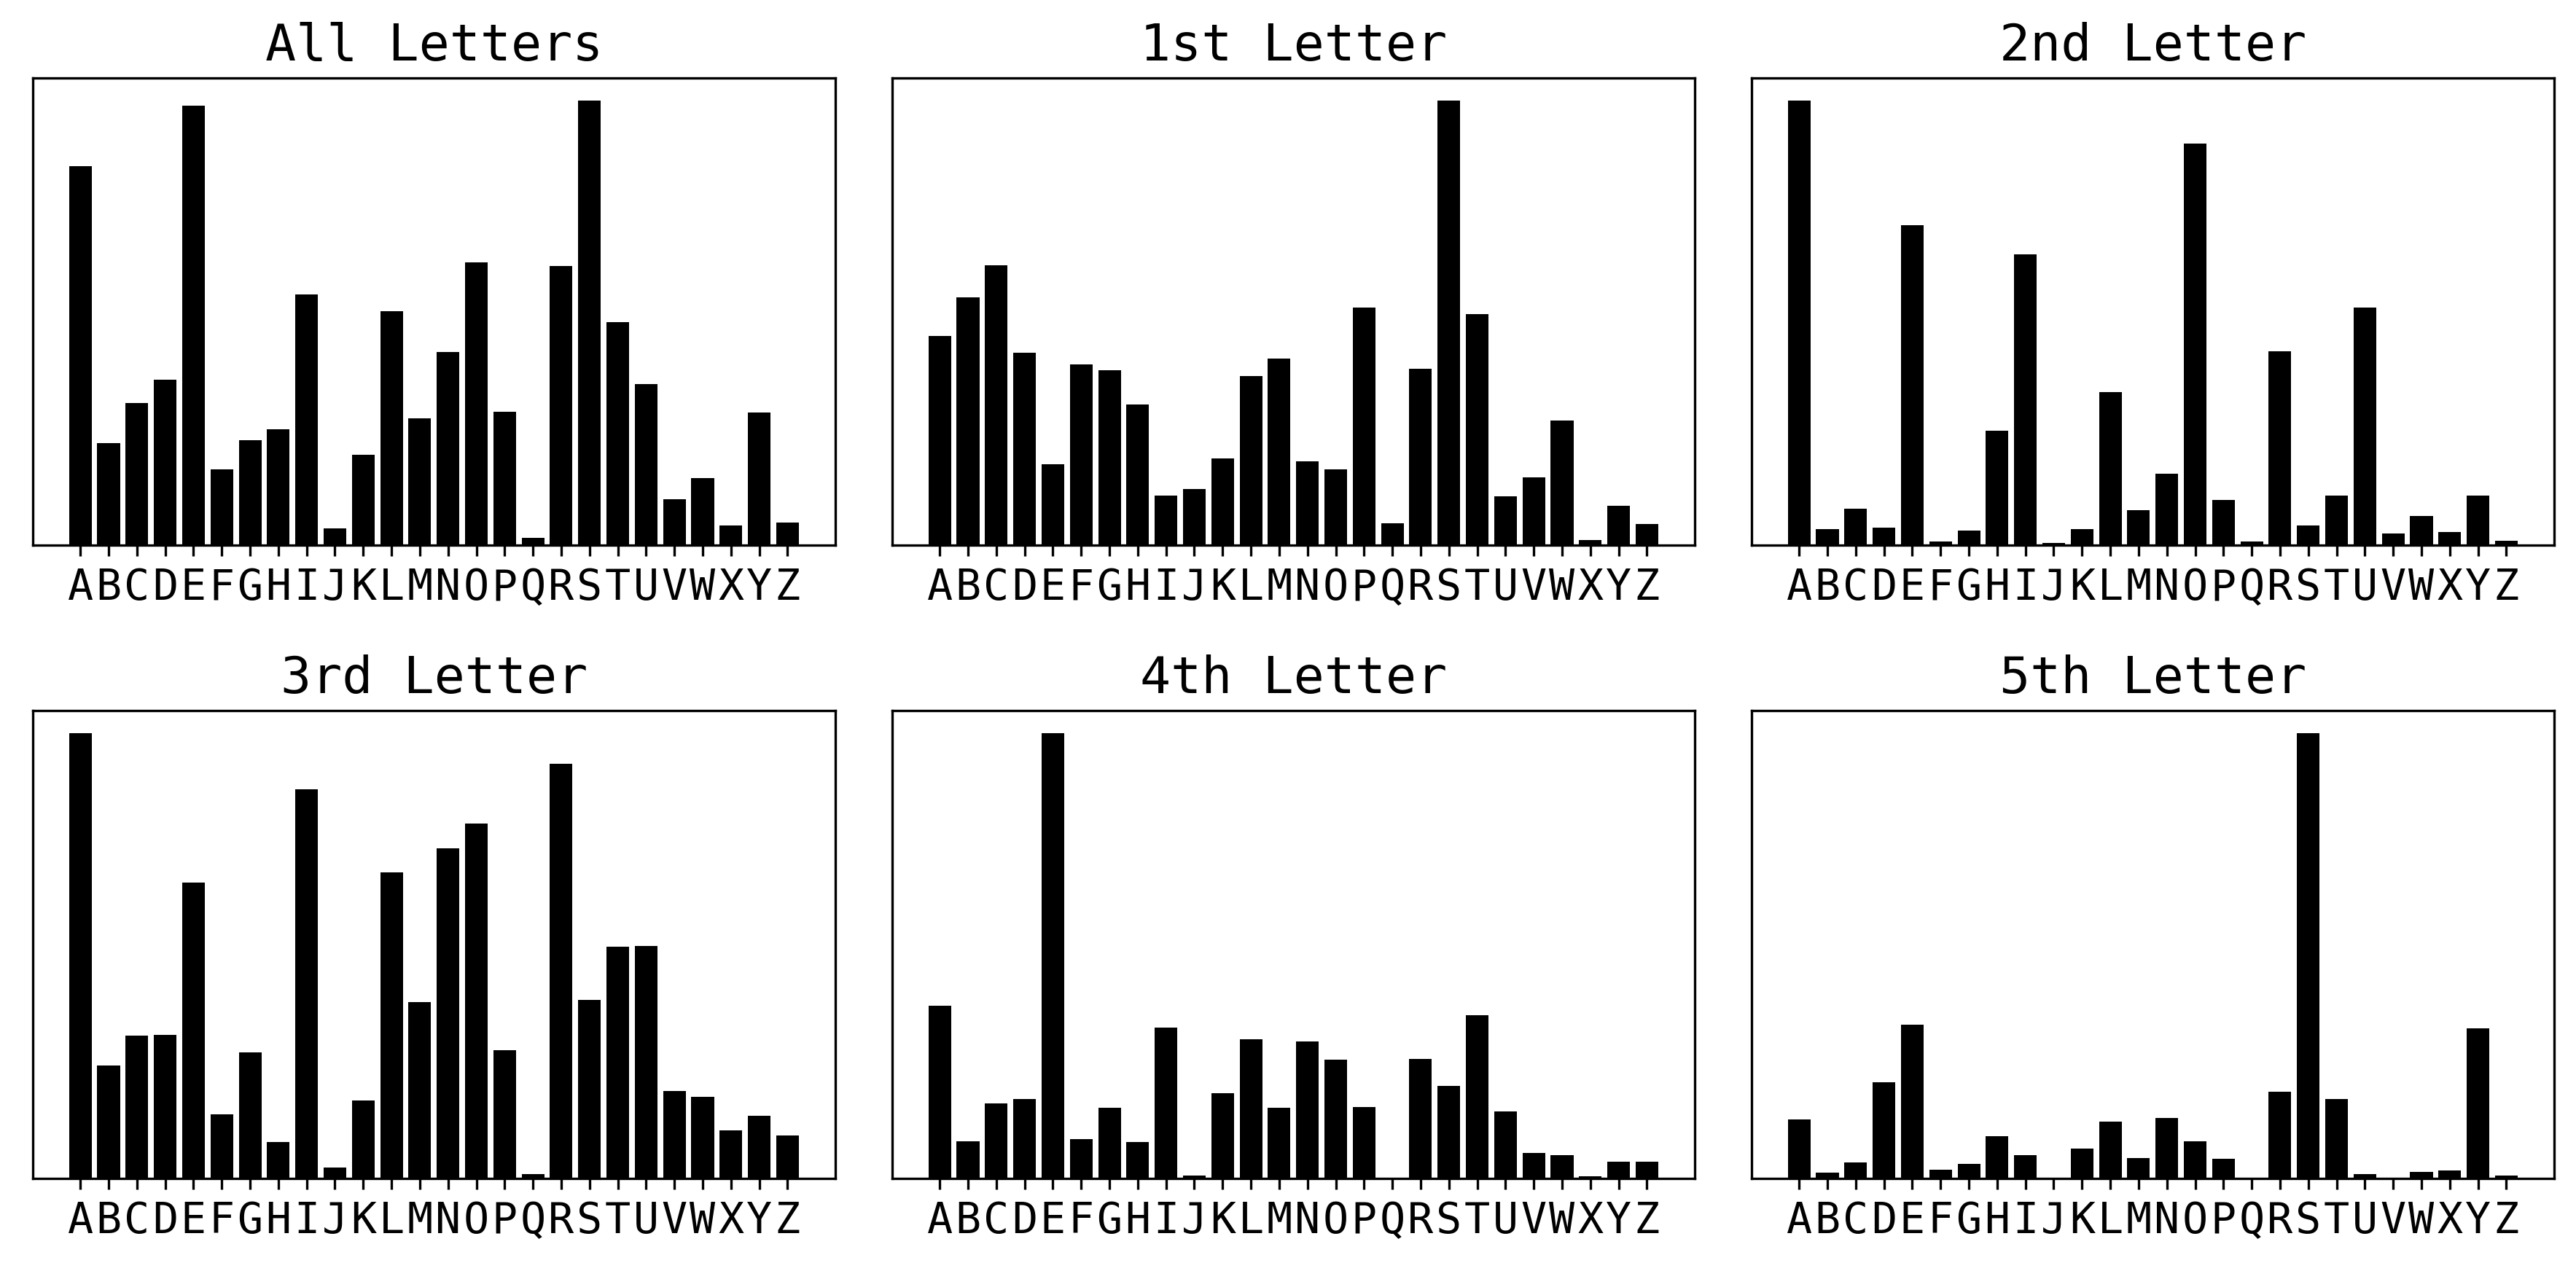

In [3]:
def position_frequency(indices, words):
    counts = dict((c, 0) for c in string.ascii_uppercase)
    counter = Counter()
    for i in indices:
            counter += Counter(w[i] for w in words)
    counts.update(counter)
    return counts

def barplot(ax, counts):
    ax.bar(np.arange(len(counts)), counts.values(), align='center', color='k')
    ax.xaxis.set_major_locator(plt.FixedLocator(np.arange(len(counts))))
    ax.xaxis.set_major_formatter(plt.FixedFormatter(list(counts.keys())))
    ax.yaxis.set_visible(False)


mapping = {(0,1,2,3,4): "All Letters", (0,): "1st Letter", (1,): "2nd Letter",
           (2,): "3rd Letter", (3,): "4th Letter", (4,): "5th Letter", }

fig = plt.figure(figsize=(12, 6), dpi=300)
axes = fig.subplots(2, 3)
for ax, key in zip(axes.flatten(), mapping):
    barplot(ax, position_frequency(key, FIVE))
    ax.set_title(mapping[key])
plt.tight_layout()
plt.show()

The 2nd letter is likely to be a vowel or an R. The 4th and 5th letters are overwhelmingly more likely to be E and S, respectively. We can safely ignore J, Q, X, and Z.

## Simulating LINGO

Guessing words with repeated letters is too complicated. Also, intuitively, it seems that words with no repeated letters may make better guesses to maximize the number of unique letters we get information on. So, I write a Lingo simulator that only handles guesses with words with 5 unique letters.

The probability of finding the correct answer across the entire set of five-letter words is then computed.

In [4]:
class Lingo:
    def __init__(self, guesses):
        assert all(len(set(w)) == 5 for w in guesses)
        self.guesses = tuple(guesses)

    def process_guesses(self, answer):
        known, unknown, wrong = dict(), defaultdict(set), set()
        known[0] = answer[0]
        for guess in self.guesses:
            for i in range(5):
                if guess[i] in answer:
                    if guess[i] == answer[i]:
                        known[i] = answer[i]
                    else:
                        unknown[i].add(guess[i])
                else:
                    wrong.add(guess[i])

        pattern = ""
        for i in range(5):
            if i in known:
                pattern += known[i]
            else:
                pattern += "[^" + "".join(sorted(wrong | unknown[i])) + "]"

        extra = set().union(*unknown.values()) - set().union(*known.values())
        return pattern, extra

    def valid_words(self, answer, words):
        p, ex = self.process_guesses(answer)
        return [w for w in words if re.fullmatch(p, w) and set(w) >= ex]

    def answer_probability(self, word_dict):
        x = []
        for c in word_dict:
            words = word_dict[c]
            x.extend(len(self.valid_words(w, words)) for w in words)
        return 1/scipy.stats.hmean(x)

def benchmark_guess(g):
    return g, Lingo(g).answer_probability(FIVE_DICT)

Let's try random sampling the list of words (with no repeated letters) and see how they do as guesses.

In [5]:
tpe = concurrent.futures.ThreadPoolExecutor(max_workers=6)
fs = []

for _ in range(18):
    fs.append(tpe.submit(benchmark_guess, random.sample(NO_REPEATS, k=4)))

print("          Pre-chosen words           |  Prob.")
print("-------------------------------------|----------")
for f in concurrent.futures.as_completed(fs):
    g, p = f.result()
    print(f"{g} | {p*100:.4f}%")

tpe.shutdown()

          Pre-chosen words           |  Prob.
-------------------------------------|----------
['CLIFT', 'DAWEN', 'BOXED', 'FETID'] | 55.2455%
['FILMY', 'WORTS', 'DHOWS', 'SWEAT'] | 73.9000%
['DOMIC', 'BALKS', 'BULKY', 'DOZER'] | 71.7809%
['SOZIN', 'WIVER', 'LADEN', 'VOMIT'] | 69.9282%
['FLOTA', 'GREYS', 'OLEIC', 'SWORD'] | 70.9588%
['BELOW', 'LAYER', 'ETYMA', 'GEARS'] | 62.7490%
['ASKOI', 'HELIO', 'BOUGH', 'TOXIC'] | 57.2487%
['BIMAH', 'GRACE', 'CHIMP', 'TIDES'] | 64.3701%
['GIFTS', 'CAKES', 'EXPAT', 'NIDES'] | 56.0792%
['LOTUS', 'VIDEO', 'LURED', 'MILCH'] | 68.5387%
['ROILS', 'CABER', 'GUIDS', 'INPUT'] | 82.0171%
['QUEYS', 'REBUS', 'LAYED', 'KOPHS'] | 65.4585%
['CASED', 'FLIED', 'PYRIC', 'NIZAM'] | 68.0639%
['SHARE', 'WEANS', 'PANIC', 'RATIO'] | 65.6091%
['BUGLE', 'DOWNS', 'BARIC', 'FLABS'] | 76.1579%
['TACHE', 'PURIS', 'WHOSE', 'PLAIT'] | 69.2682%
['FLAMY', 'FUMER', 'WRITE', 'BUNKS'] | 80.4308%
['FLAWY', 'CUSHY', 'FINED', 'POUCH'] | 71.7578%


The more unique letters we sample through our four guess words, the better the probability of getting the correct answer. If we try to be a bit more systematic, we can pick a guess word that looks like a typical five-letter word (based on letter frequencies at each position), and then pick three additional words such that we have 20 unique letters in total. I pick random words that end with "RES" (the most popular suffix) and then try to find three other words which all have no letters in common. I also exclude "J", "Q", "X", and "Z" entirely as they are quite rare.

In [8]:
import time

def benchmark_guess(g):
    return g, Lingo(g).answer_probability(FIVE_DICT)

X = [w for w in NO_REPEATS if re.fullmatch("[^JQXZ]"*5, w)]
RES = [w for w in X if w.endswith('RES')]
NO_RES = [w for w in X if re.fullmatch("[^RES]"*5, w)]

tpe = concurrent.futures.ThreadPoolExecutor(max_workers=6)
fs = []

t0 = time.time()
while time.time() < t0 + 1200:
    first = random.choice(RES)
    NO_FIRST = [w for w in NO_RES if re.fullmatch(f"[^{first}]"*5, w)]
    t1 = time.time()
    while time.time() < t1 + 30:
        g = [first] + random.sample(NO_FIRST, k=3)
        if len(set.union(*map(set, g))) == 20:
            fs.append(tpe.submit(benchmark_guess, g))

print("          Pre-chosen words           |  Prob.")
print("-------------------------------------|-----------")

best = 0
for f in concurrent.futures.as_completed(fs):
    g, p = f.result()
    if p > best:
        best = p
        print(f"{g} | {p*100:.4f}%")

tpe.shutdown()

          Pre-chosen words           |  Prob.
-------------------------------------|-----------
['VIRES', 'WHACK', 'PODGY', 'BLUNT'] | 94.2682%
['NARES', 'WIGHT', 'DUMPY', 'BLOCK'] | 94.9166%
['LORES', 'BUNDT', 'PIGMY', 'WHACK'] | 94.9629%
['TARES', 'DINGY', 'BLOCK', 'WHUMP'] | 95.0556%
['PYRES', 'FLOCK', 'WIGHT', 'MAUND'] | 95.0903%
['MIRES', 'BLUNT', 'WHACK', 'PODGY'] | 95.1945%
['PYRES', 'BLOCK', 'MAUND', 'WIGHT'] | 95.2640%


In [9]:
guesses = [['APRES', 'CLOMB', 'GUNKY', 'WIDTH'],
           ['GYRES', 'MAUND', 'BLOCK', 'WHIPT'],
           ['CARES', 'KLONG', 'BUMPY', 'WIDTH']]

print("          Pre-chosen words           |  Prob.")
print("-------------------------------------|-----------")
for g in guesses:
    g, p = benchmark_guess(g)
    print(f"{g} | {p*100:.4f}%")

          Pre-chosen words           |  Prob.
-------------------------------------|-----------
['APRES', 'CLOMB', 'GUNKY', 'WIDTH'] | 95.3103%
['GYRES', 'MAUND', 'BLOCK', 'WHIPT'] | 95.4145%
['CARES', 'KLONG', 'BUMPY', 'WIDTH'] | 95.7388%
